In [1]:
using Yao
using Yao.EasyBuild: variational_circuit
import Yao: tracedist

"""
Quantum GAN.

Reference:
    Benedetti, M., Grant, E., Wossnig, L., & Severini, S. (2018). Adversarial quantum circuit learning for pure state approximation, 1–14.
"""
struct QuGAN
    nqubits::Int
    target::ArrayReg
    generator::AbstractBlock
    discriminator::AbstractBlock
    reg0::ArrayReg
    witness_op::AbstractBlock
    circuit::AbstractBlock

    function QuGAN(target::ArrayReg, gen::AbstractBlock, dis::AbstractBlock)
        N = nqubits(target)
        c = chain(subroutine(N+1, gen, 1:N), dis)
        witness_op = put(N+1, (N+1)=>ConstGate.P0)
        new(N+1, join(zero_state(1), target), subroutine(N+1, gen, 1:N), dis, zero_state(N+1), witness_op, c)
    end
end

# INTERFACES
circuit(qg::QuGAN) = qg.circuit # this just defines the function circuit(qg) to be qg.circuit
loss(qg::QuGAN) = p0t(qg) - p0g(qg)

function gradient(qg::QuGAN)
    grad_gen = expect'(qg.witness_op, qg.reg0 => qg.circuit).second #i don't know what second means here... maybe the second component?
    grad_tar = expect'(qg.witness_op, qg.target => qg.circuit[2]).second 
    ngen = nparameters(qg.generator)
    [-grad_gen[1:ngen]; grad_tar - grad_gen[ngen+1:end]] #output
end

"""probability to get evidense qubit 0 on generation set."""
p0g(qg::QuGAN) = expect(qg.witness_op, qg.reg0 => qg.circuit) |> real
"""probability to get evidense qubit 0 on target set."""
p0t(qg::QuGAN) = expect(qg.witness_op, qg.target => qg.circuit[2]) |> real


"""generated wave function"""
outputψ(qg::QuGAN) = copy(qg.reg0) |> qg.generator

"""tracedistance between target and generated wave function"""
tracedist(qg::QuGAN) = tracedist(qg.target, outputψ(qg))[]

using Test, Random
Random.seed!(2) #Setting the seed, so target = rand_state(nbit) is always the same thing

nbit = 2
depth_gen = 4
depth_dis = 4

# define a QuGAN
target = rand_state(nbit) #Make random state on n qubits
generator = dispatch!(variational_circuit(nbit, depth_gen), :random) #Putting in random parameters into a variational_circuit
discriminator = dispatch!(variational_circuit(nbit+1, depth_dis), :random) #Needs 1 more bit so it can take in the generator output and also output a decision
qg = QuGAN(target, generator, discriminator)

qg.target |> statevec |> println
qg |> p0g |> println
qg |> p0t |> println
abs2(statevec(qg.target)[1])

ComplexF64[-0.002108582862575444 + 0.6377947603146041im, -0.38587403310152446 + 0.21146340797530896im, -0.13502513116785017 + 0.37015918062159403im, -0.46885500042982203 - 0.15659897440783682im, -0.0 + 0.0im, -0.0 + 0.0im, -0.0 + 0.0im, 0.0 - 0.0im]


0.35637054977937055
0.5382123821503453


0.4067866024064517

In [2]:
# check the gradient
grad = gradient(qg)

# learning rates for the generator and discriminator
g_lr = 0.2
d_lr = 0.5
ng = nparameters(qg.generator)
epochs = 10
t = []
for i=1:epochs
    grad = gradient(qg)
    print(grad[1:ng])
    dispatch!(-, qg.generator, grad[1:ng]*g_lr) #Rule is - (as specified by first input), this is basically just doing gradient descent
    dispatch!(-, qg.discriminator, -grad[ng+1:end]*d_lr)
    tt = tracedist(qg)
    push!(t, tt)
    println("Step $i, trace distance = $tt")
end

@test qg |> loss < 0.1

[0.0027573380101979933, -0.015208164574469468, 0.22274528273891483, -0.08532640475251987, -0.08532640475251979, 0.11910695927863989, 0.057277908918612314, -0.04671935113795894, 0.050433331425915856, -0.07834673622981009, -0.07834673622981006, -0.06870766813215769, -0.19701000975060345, 0.01975907012684798, -0.18135510692959186, 0.11449251342729487, 0.11449251342729484, -0.15190098240569416, 0.18302447684770945, 0.2804943818666146, 0.052818897329558884, 0.27425022357338247, 0.27425022357338247, 0.15328740373116406, -0.02747733901543238, -0.2576352631303387]

Step 1, trace distance = 1.4578755396292074
[-0.014937405223547362, -0.04947646703626051, 0.18675379959147853, 0.04248112083347097, 0.04248112083347097, 0.03513918028100199, 0.22479738868033802, -0.0699196179150387, 0.13819912245096796, -0.17084828606149158, -0.17084828606149158, -0.04902484558726167, -0.24548136252038405, 0.02925153943127068, -0.22538477122932352, 0.07715848912687993, 0.07715848912687993, -0.08067214319333847, 0.1280239057858018, 0.21699928446126202, 0.005887016572028433, 0.20967376099891355, 0.20967376099891355, 0.24614870437930564, -0.06677637092807492, -0.19495252601856827]Step 2, trace distance = 1.426726819890476
[0.001053837790260359, -0.013223859518131723, 0.26340339692189996, 0.03360344017930633, 0.033603440179306276, 0.025783024116680597, 0.21442657310541, -0.0406581620563668, 0.10212326860068371, -0.11708500114293383, -0.11708500114293383, -0.11040652351477286, -0.21049328535084602, 0.08583277996365647, -0.2450511332170936, 0.13900738623828107, 0.13900738623

Test Failed at /Users/pluo/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/qGAN.ipynb:20
  Expression: qg |> loss < 0.1
   Evaluated: 0.35506091296032416 < 0.1



Test.FallbackTestSetException: Test.FallbackTestSetException("There was an error during testing")

In [3]:
# reg |> uniform_state(nbit)
# typeof(qg.generator)

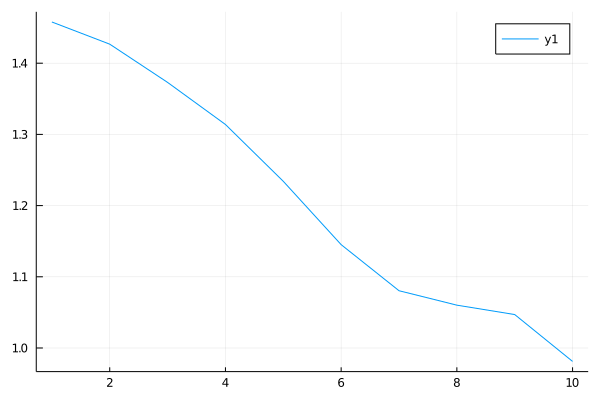

In [4]:
using Plots

plot(t)

In [5]:
qg.target |> print_table

000 ₍₂₎   -0.00211 + 0.63779im
001 ₍₂₎   -0.38587 + 0.21146im
010 ₍₂₎   -0.13503 + 0.37016im
011 ₍₂₎   -0.46886 - 0.1566im
100 ₍₂₎   -0.0 + 0.0im
101 ₍₂₎   -0.0 + 0.0im
110 ₍₂₎   -0.0 + 0.0im
111 ₍₂₎   0.0 - 0.0im


In [6]:
#qg.reg0 |> print_table 
qg |> outputψ |> print_table

000 ₍₂₎   0.1652 + 0.52749im
001 ₍₂₎   -0.55709 + 0.45359im
010 ₍₂₎   -0.054 + 0.31429im
011 ₍₂₎   -0.16277 + 0.224im
100 ₍₂₎   0.0 + 0.0im
101 ₍₂₎   0.0 + 0.0im
110 ₍₂₎   0.0 + 0.0im
111 ₍₂₎   0.0 + 0.0im
